In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/offense-language-detection/DATASET/test_labels.csv
/kaggle/input/offense-language-detection/DATASET/validation.csv
/kaggle/input/offense-language-detection/DATASET/train.csv
/kaggle/input/offense-language-detection/DATASET/test.csv


In [2]:
! pip install -q scikit-multilearn
! pip install -q transformers
! pip install -q tensorflow-text
! pip install -q tf-models-official
! pip install deep_translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [3]:
### Imports ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

In [4]:
### Style settings ###
plt.style.use('ggplot')
sns.set_palette("Set2")

# **Step 1: Exploratory Data Analysis (EDA)**

In [5]:
### Read data ###
train_df = pd.read_csv("/kaggle/input/offense-language-detection/DATASET/train.csv")
test_df = pd.read_csv("/kaggle/input/offense-language-detection/DATASET/test.csv")
val_df = pd.read_csv("/kaggle/input/offense-language-detection/DATASET/validation.csv") 

In [6]:
train_df.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


### ***Visualize Label Distribution Across Toxicity Types***

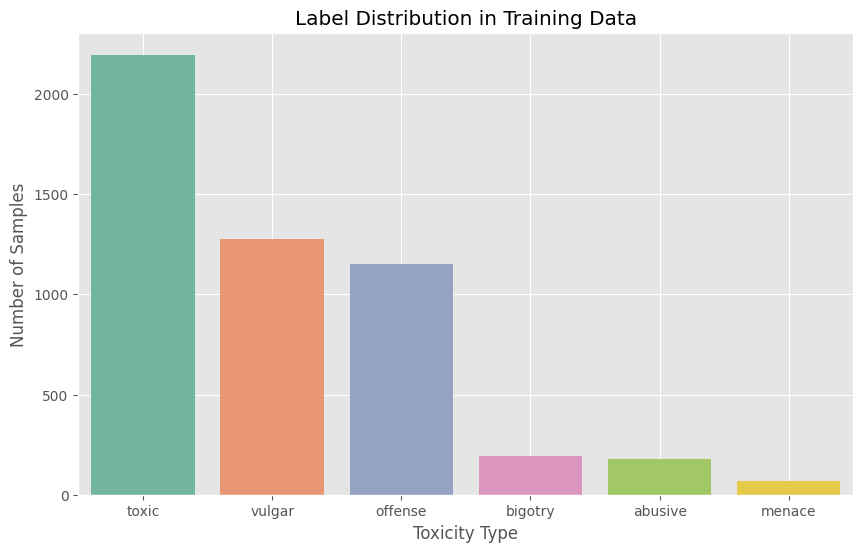

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']

# Plot count of each label
label_counts = train_df[labels].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Label Distribution in Training Data")
plt.ylabel("Number of Samples")
plt.xlabel("Toxicity Type")
plt.grid(True)
plt.show()

### ***Class Imbalance Analysis***

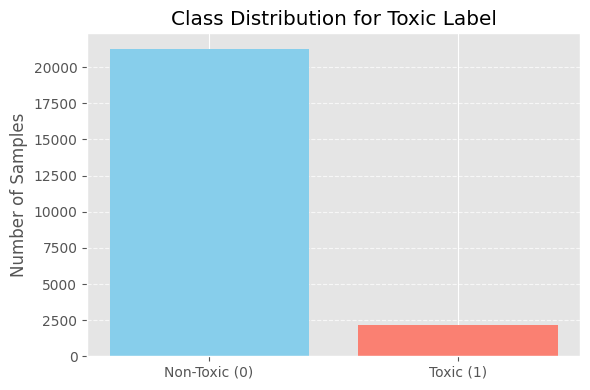

In [8]:
# Count values for 'toxic' column
class_counts = train_df['toxic'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Non-Toxic (0)', 'Toxic (1)'], class_counts.values, color=['skyblue', 'salmon'])
plt.title('Class Distribution for Toxic Label')
plt.ylabel('Number of Samples')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### ***Analyze Sentence Structure (Length, Word Distribution, Common Words)***

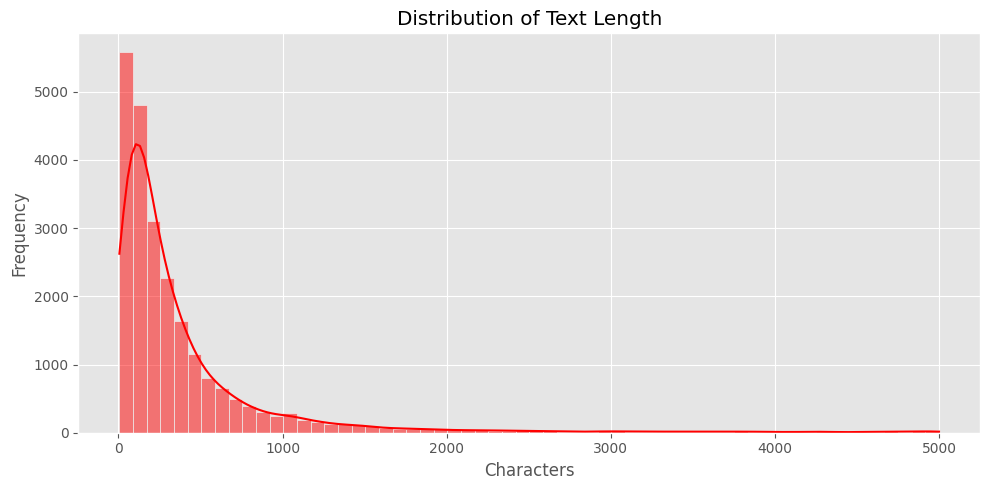

In [9]:
# Add sentence length column
train_df['text_length'] = train_df['feedback_text'].astype(str).apply(len)

# Sentence Length Distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['text_length'], bins=60, kde=True, color='red')
plt.title('Distribution of Text Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

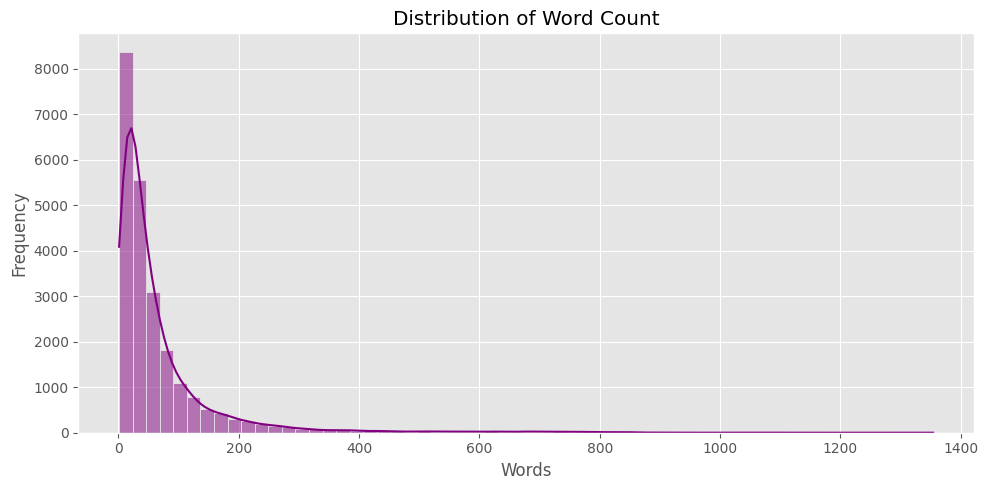

In [10]:
train_df['word_count'] = train_df['feedback_text'].astype(str).apply(lambda x: len(x.split()))

# Word Count Distribution
plt.figure(figsize=(10, 5))
sns.histplot(train_df['word_count'], bins=60, kde=True, color='purple')
plt.title('Distribution of Word Count')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


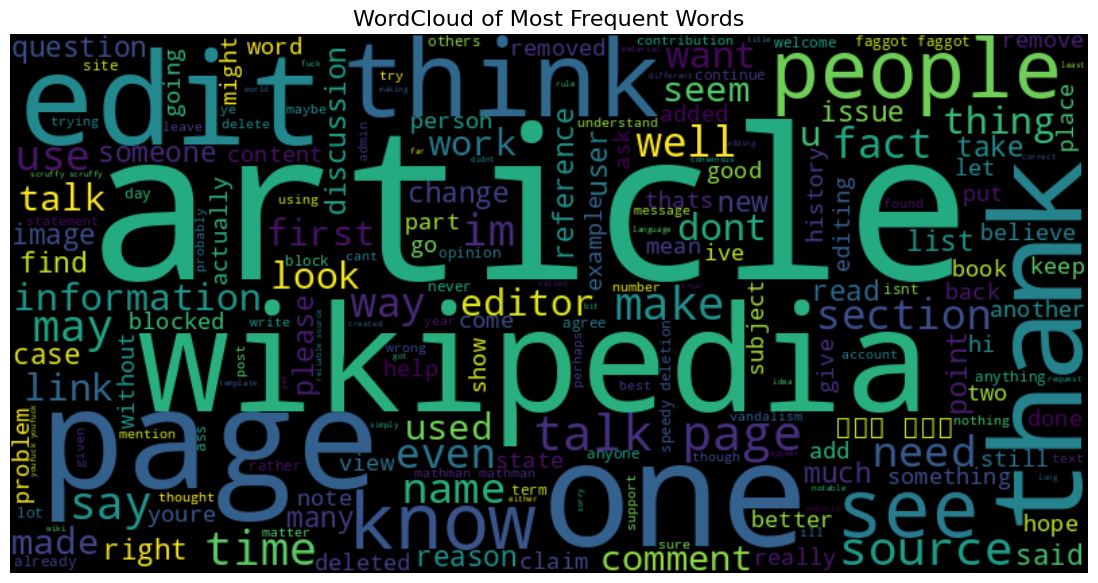

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

# Download stopwords from nltk
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))

wordcloud_stopwords = set(STOPWORDS)
combined_stopwords = nltk_stopwords.union(wordcloud_stopwords)

all_text = ' '.join(train_df['feedback_text'].astype(str)).lower()

# Remove punctuation manually for better results
all_text = all_text.translate(str.maketrans('', '', string.punctuation))

wordcloud = WordCloud(width=800, height=400,
                      stopwords=combined_stopwords,
                      colormap='viridis',  # Gradient color map
                      max_words=200).generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Most Frequent Words", fontsize=16)
plt.show()

### ***Check for missing values or outliers***

In [12]:
print("Missing values in each column:\n")
print(train_df.isnull().sum())

Missing values in each column:

id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
text_length      0
word_count       0
dtype: int64


In [13]:
train_df.dropna(subset=['feedback_text'], inplace=True)

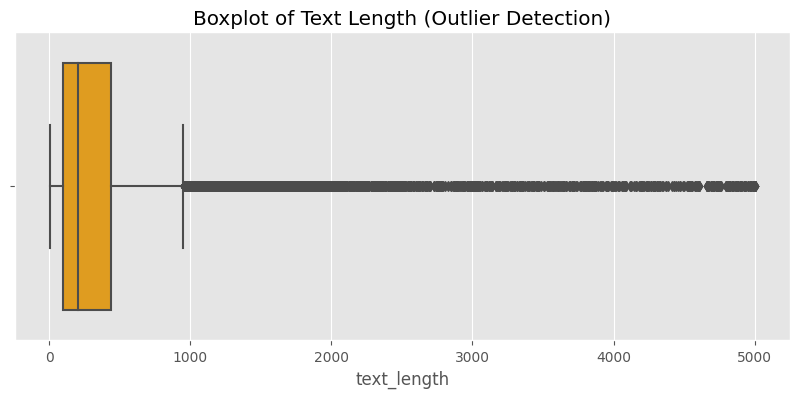

In [14]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_df['text_length'], color='orange')
plt.title('Boxplot of Text Length (Outlier Detection)')
plt.show()

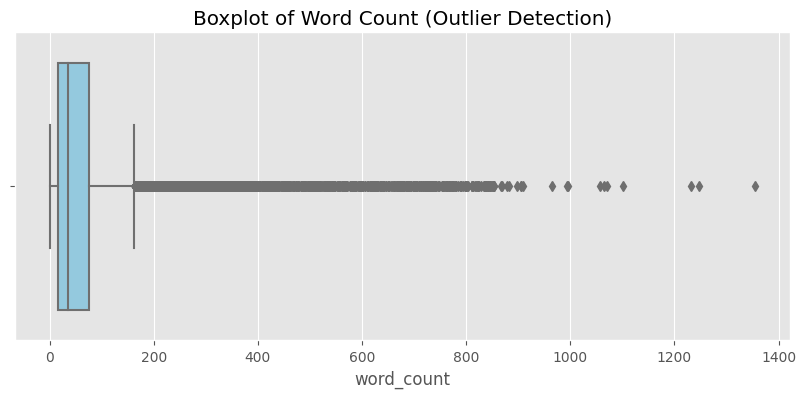

In [15]:
# Calculate word count if not already present
train_df['word_count'] = train_df['feedback_text'].apply(lambda x: len(str(x).split()))

# Plot boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=train_df['word_count'], color='skyblue')
plt.title('Boxplot of Word Count (Outlier Detection)')
plt.show()

In [16]:
# Text Length thresholds
len_low, len_high = train_df['text_length'].quantile([0.01, 0.99])

# Word Count thresholds
word_low, word_high = train_df['word_count'].quantile([0.01, 0.99])

outliers = train_df[
    (train_df['text_length'] < len_low) | (train_df['text_length'] > len_high) |
    (train_df['word_count'] < word_low) | (train_df['word_count'] > word_high)
]

print(f"Total samples: {len(train_df)}")
print(f"Outliers detected: {len(outliers)}")
print(f"Outlier percentage: {100 * len(outliers)/len(train_df):.2f}%")

Total samples: 23473
Outliers detected: 504
Outlier percentage: 2.15%


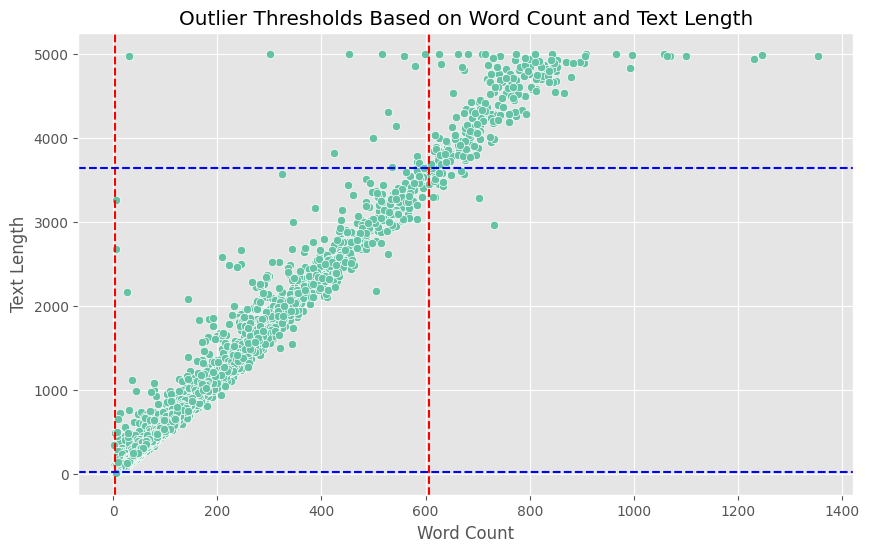

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='word_count', y='text_length')
plt.axvline(word_low, color='red', linestyle='--')
plt.axvline(word_high, color='red', linestyle='--')
plt.axhline(len_low, color='blue', linestyle='--')
plt.axhline(len_high, color='blue', linestyle='--')
plt.title('Outlier Thresholds Based on Word Count and Text Length')
plt.xlabel('Word Count')
plt.ylabel('Text Length')
plt.grid(True)
plt.show()

# **Step 2: Text Preprocessing**

### ***Tokenization, Stemming/Lemmatization, Lowercasing, Removing Stop Words, Special haracters, and Punctuation***

In [18]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from deep_translator import GoogleTranslator

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Tokenization, Lowercasing, Removing stop words, special characters, punctuation
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters, digits, and punctuation using regex
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra spaces (replace multiple spaces with a single space)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in combined_stopwords]

    return tokens

# Stemming and Lemmatization
def apply_stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def apply_lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Example text preprocessing function
def text_preprocessing(text, use_stemming=True):

    tokens = preprocess_text(text)
    
    if use_stemming:
        return apply_stemming(tokens)
    else:
        return apply_lemmatization(tokens)

# Example of preprocessing a single text
example_text = train_df['feedback_text'][0]

preprocessed_text = text_preprocessing(example_text, use_stemming=True)
print(preprocessed_text)

['sound', 'good', 'let', 'know', 'your', 'done', 'ill', 'start', 'pr']


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### ***Feature Extraction using TF-IDF***

In [19]:
# Feature Extraction: TF-IDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Converting text to numeric vectors
def tfidf_feature_extraction(text_data, vectorizer=None):
    if vectorizer is None:
        # Fit a new vectorizer on training data
        vectorizer = TfidfVectorizer(max_features=5000, min_df=3)
        tfidf_matrix = vectorizer.fit_transform(text_data)
    else:
        # Use the existing vectorizer for test data
        tfidf_matrix = vectorizer.transform(text_data)
    return tfidf_matrix, vectorizer


train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 1)

# Preprocess all text in the DataFrame
train_df['processed_text'] = train_df['feedback_text'].apply(text_preprocessing)
val_df['processed_text'] = val_df['feedback_text'].apply(text_preprocessing)
test_df['processed_text'] = test_df['content'].apply(text_preprocessing)

# Join the tokens back into a string for TF-IDF vectorization
train_df['processed_text'] = train_df['processed_text'].apply(lambda x: ' '.join(x))
val_df['processed_text'] = train_df['processed_text'].apply(lambda x: ' '.join(x))
test_df['processed_text'] = test_df['processed_text'].apply(lambda x: ' '.join(x))

# Extract TF-IDF features
X_train_tfidf, tfidf_vectorizer = tfidf_feature_extraction(train_df['processed_text'])
X_test_tfidf, _ = tfidf_feature_extraction(test_df['processed_text'], tfidf_vectorizer)  

# Print out the results
print("TF-IDF Matrix Shape:", X_train_tfidf.shape)
print("Sample TF-IDF Feature Names:", tfidf_vectorizer.get_feature_names_out()[:100])

TF-IDF Matrix Shape: (18778, 5000)
Sample TF-IDF Feature Names: ['aa' 'abandon' 'abbrevi' 'abc' 'abid' 'abil' 'abl' 'abort' 'abraham'
 'absenc' 'absolut' 'abstract' 'absurd' 'abund' 'abus' 'ac' 'academ'
 'academi' 'acceler' 'accent' 'accept' 'access' 'accid' 'accident'
 'accompani' 'accomplish' 'accord' 'accordingli' 'account' 'accredit'
 'accur' 'accuraci' 'accus' 'ace' 'achiev' 'acid' 'acknowledg' 'acquir'
 'acronym' 'across' 'act' 'action' 'activ' 'activist' 'actor' 'actress'
 'actual' 'ad' 'adam' 'adapt' 'add' 'addict' 'addit' 'address' 'adequ'
 'adher' 'adject' 'adjust' 'admin' 'administ' 'administr' 'adminship'
 'admir' 'admiss' 'admit' 'admittedli' 'adolesc' 'adolf' 'adopt' 'adult'
 'advanc' 'advantag' 'adventur' 'advert' 'advertis' 'advic' 'advis'
 'advoc' 'advocaci' 'ae' 'aesthet' 'afc' 'afd' 'affair' 'affect' 'affili'
 'affirm' 'afford' 'afghan' 'afghanistan' 'afraid' 'africa' 'african'
 'aftermath' 'afternoon' 'afterward' 'age' 'agenc' 'agenda' 'agent']


# **Step 3: Model Creation**

### ***Evaluation Function***

In [20]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_test, y_pred, y_proba):
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")
    print(f"Confusion Matrix:\n, {confusion_matrix(y_test, y_pred)}\n")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
test_labels = pd.read_csv('/kaggle/input/offense-language-detection/DATASET/test_labels.csv')

y_train = train_df[labels]
y_val = val_df[labels]
y_test = test_labels['toxic']

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(18778, 6)
(4695, 6)
(6000,)


# **Baseline Models**

## ***Logistic Regression***

### ***Applying Logistic Regression with TF-IDF vectorization***

Accuracy: 0.7515
Precision: 0.2698
Recall: 0.0550
F1 Score: 0.0914
ROC AUC: 0.5399

Confusion Matrix:
, [[4434  203]
 [1288   75]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86      4637
           1       0.27      0.06      0.09      1363

    accuracy                           0.75      6000
   macro avg       0.52      0.51      0.47      6000
weighted avg       0.66      0.75      0.68      6000



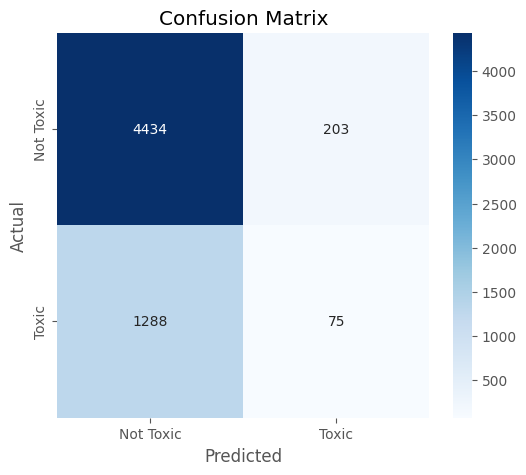

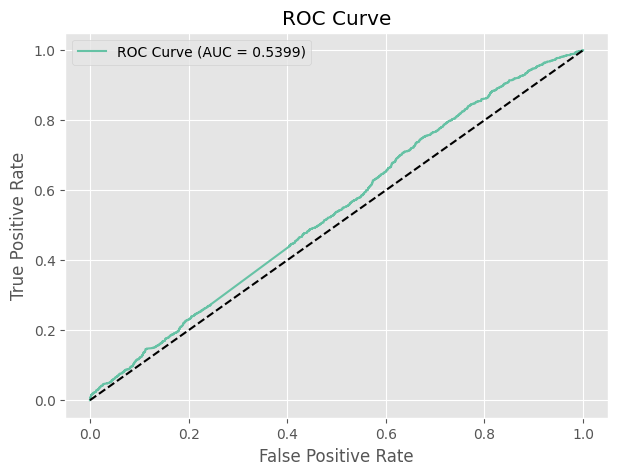

In [22]:
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance

# Logistic Regression
clf = BinaryRelevance(LogisticRegression(solver='liblinear', class_weight='balanced'))
clf.fit(X_train_tfidf, y_train)

# Predicting on test data
y_pred = clf.predict(X_test_tfidf).toarray()[:, 0]
y_proba = clf.predict_proba(X_test_tfidf).toarray()[:, 0]

evaluate_model(y_test, y_pred, y_proba)

# **Model Tuning**

### ***Using Grid Search***

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best score: 0.6473347934633341
Accuracy: 0.7720
Precision: 0.4747
Recall: 0.0345
F1 Score: 0.0643
ROC AUC: 0.5540

Confusion Matrix:
, [[4585   52]
 [1316   47]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87      4637
           1       0.47      0.03      0.06      1363

    accuracy                           0.77      6000
   macro avg       0.63      0.51      0.47      6000
weighted avg       0.71      0.77      0.69      6000



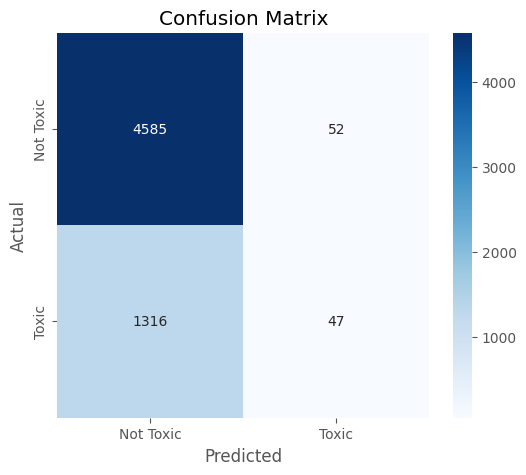

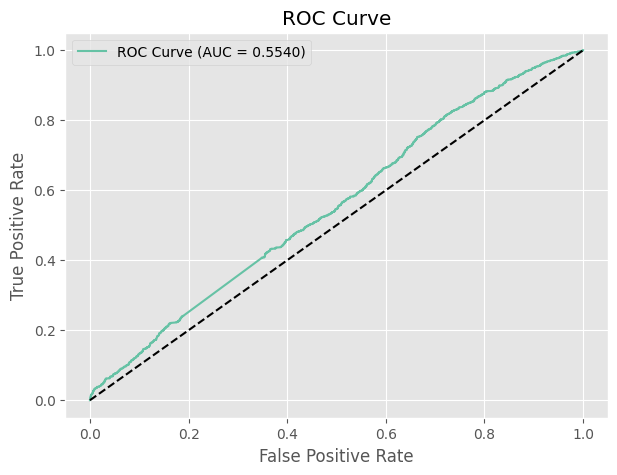

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.metrics import make_scorer, accuracy_score, f1_score

# Define the parameter grid for Logistic Regression
param_grid = {
    'classifier__C': [0.01, 1, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear']
}

# Create BinaryRelevance with LogisticRegression
clf = BinaryRelevance(LogisticRegression(class_weight='balanced'))

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,
    scoring=make_scorer(f1_score, average='weighted'),
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Predict with the best model
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_tfidf).toarray()[:, 0]
y_proba = best_clf.predict_proba(X_test_tfidf).toarray()[:, 0]

# Evaluate
evaluate_model(y_test, y_pred, y_proba)

### ***Using Random Search***

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'classifier__C': 0.014271483774997193, 'classifier__max_iter': 300, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best score: 0.6488783695522992
Accuracy: 0.7707
Precision: 0.4404
Recall: 0.0352
F1 Score: 0.0652
ROC AUC: 0.5537

Confusion Matrix:
, [[4576   61]
 [1315   48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.87      4637
           1       0.44      0.04      0.07      1363

    accuracy                           0.77      6000
   macro avg       0.61      0.51      0.47      6000
weighted avg       0.70      0.77      0.69      6000



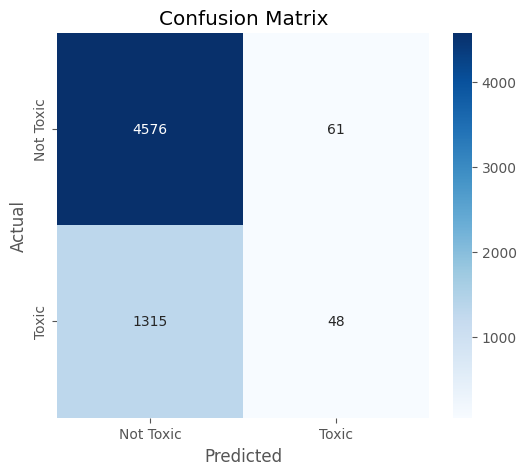

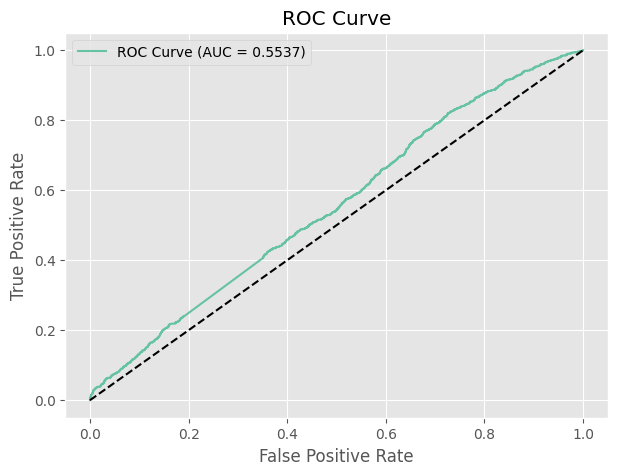

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Define the parameter distribution for Logistic Regression
param_dist = {
    'classifier__C': loguniform(1e-3, 1e2),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100, 200, 300]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring=make_scorer(f1_score, average='weighted'),
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train_tfidf, y_train)

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Predict with the best model
best_clf = random_search.best_estimator_
y_pred = best_clf.predict(X_test_tfidf).toarray()[:, 0]
y_proba = best_clf.predict_proba(X_test_tfidf).toarray()[:, 0]

# Evaluate
evaluate_model(y_test, y_pred, y_proba)

### ***Applying Logistic Regression with multilingual sentence embeddings***

2025-04-13 11:14:58.897612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744542898.916539      19 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744542898.923499      19 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744542898.942992      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744542898.943014      19 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744542898.943017      19 computation_placer.cc:177] computation placer alr

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/587 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 0.8065
Precision: 0.6010
Recall: 0.4409
F1 Score: 0.5087
ROC AUC: 0.7850

Confusion Matrix:
, [[4238  399]
 [ 762  601]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      4637
           1       0.60      0.44      0.51      1363

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.79      0.81      0.80      6000



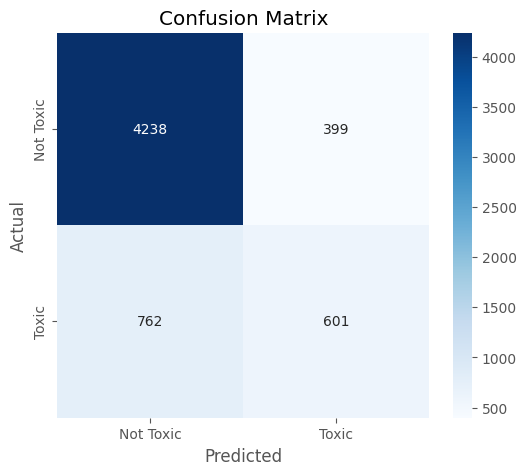

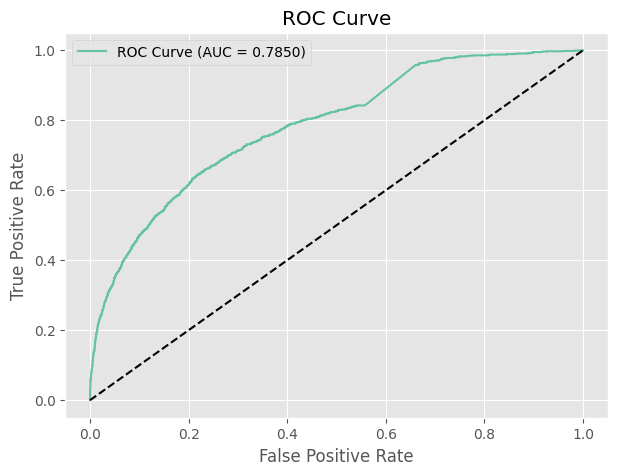

In [25]:
from sentence_transformers import SentenceTransformer

# Load multilingual sentence embedding model
model = SentenceTransformer('distiluse-base-multilingual-cased-v1') 

# Preprocess text
train_df_pt = train_df['feedback_text'].apply(text_preprocessing).apply(lambda x: ' '.join(x))
test_df_pt = test_df['content'].apply(text_preprocessing).apply(lambda x: ' '.join(x))

# Generate sentence embeddings
X_train_embed = model.encode(train_df_pt.tolist(), show_progress_bar=True)
X_test_embed = model.encode(test_df_pt.tolist(), show_progress_bar=True)

# Train classifier
clf = BinaryRelevance(LogisticRegression(solver='liblinear', class_weight='balanced'))
clf.fit(X_train_embed, y_train)

# Predict
y_pred = clf.predict(X_test_embed).toarray()[:, 0]
y_proba = clf.predict_proba(X_test_embed).toarray()[:, 0]

# Evaluation
evaluate_model(y_test, y_pred, y_proba)

## ***Random Forest***

### ***Applying Logistic Regression with TF-IDF vectorization***

Accuracy: 0.3593
Precision: 0.2424
Recall: 0.8562
F1 Score: 0.3778
ROC AUC: 0.5636

Confusion Matrix:
, [[ 989 3648]
 [ 196 1167]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.21      0.34      4637
           1       0.24      0.86      0.38      1363

    accuracy                           0.36      6000
   macro avg       0.54      0.53      0.36      6000
weighted avg       0.70      0.36      0.35      6000



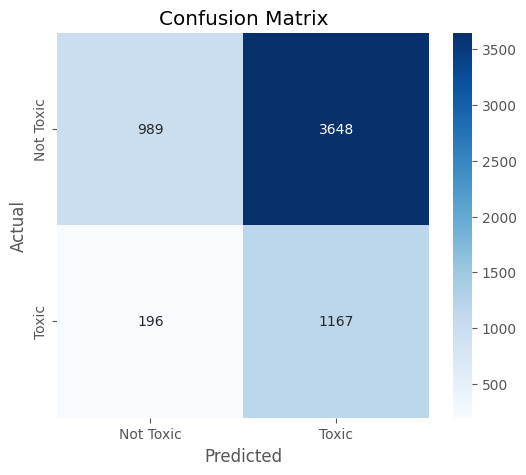

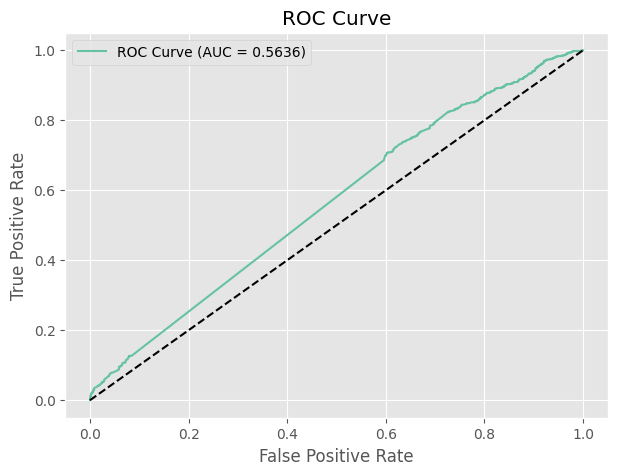

In [26]:
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import BinaryRelevance

# Train classifier with Random Forest
clf = BinaryRelevance(RandomForestClassifier(n_estimators=100, max_depth=30, class_weight='balanced', n_jobs=-1, random_state=42))
clf.fit(X_train_tfidf, y_train)

# Predict
y_pred = clf.predict(X_test_tfidf).toarray()[:, 0]
y_proba = clf.predict_proba(X_test_tfidf).toarray()[:, 0]

# Evaluation
evaluate_model(y_test, y_pred, y_proba)

### ***Using Random Search***

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Accuracy: 0.4480
Precision: 0.2552
Recall: 0.7454
F1 Score: 0.3802
ROC AUC: 0.5722

Confusion Matrix:
, [[1672 2965]
 [ 347 1016]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.36      0.50      4637
           1       0.26      0.75      0.38      1363

    accuracy                           0.45      6000
   macro avg       0.54      0.55      0.44      6000
weighted avg       0.70      0.45      0.47      6000



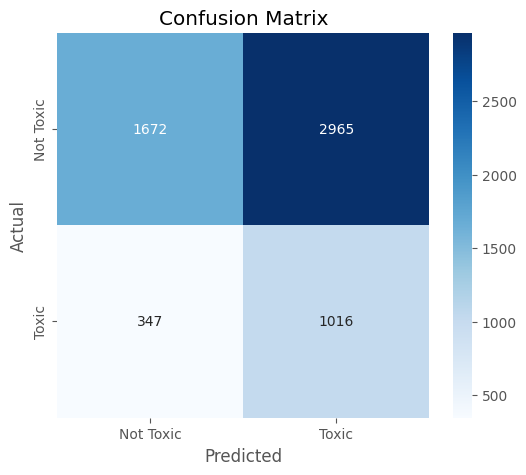

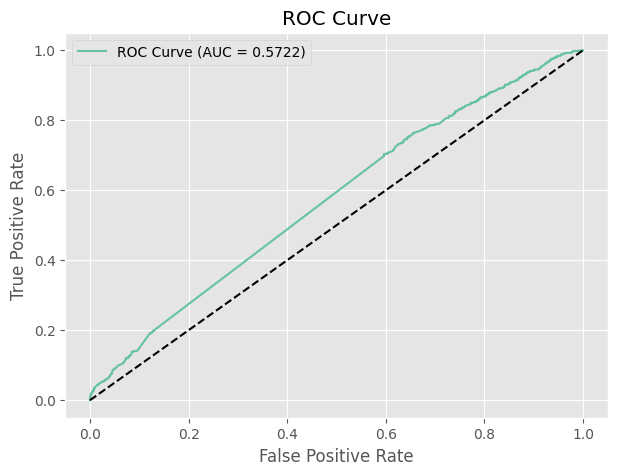

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distributions
param_dist = {
    'classifier__n_estimators': randint(30, 100),
    'classifier__max_depth': [None] + list(randint(5, 50).rvs(10)),
    'classifier__min_samples_split': randint(2, 11),
    'classifier__min_samples_leaf': randint(1, 5),
    'classifier__class_weight': ['balanced']
}

# Create base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
br_model = BinaryRelevance(rf)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=br_model,
    param_distributions=param_dist,
    n_iter=20,  
    cv=3,
    scoring='f1_micro',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Perform random search
random_search.fit(X_train_tfidf, y_train)

# Get best model
best_clf = random_search.best_estimator_

# Predict and evaluate (for first label)
y_pred = best_clf.predict(X_test_tfidf).toarray()[:, 0]
y_proba = best_clf.predict_proba(X_test_tfidf).toarray()[:, 0]

evaluate_model(y_test, y_pred, y_proba)

### ***Applying Random Forest with multilingual sentence embeddings***

Batches:   0%|          | 0/587 [00:00<?, ?it/s]

Batches:   0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 0.7778
Precision: 0.8750
Recall: 0.0257
F1 Score: 0.0499
ROC AUC: 0.7209

Confusion Matrix:
, [[4632    5]
 [1328   35]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.87      4637
           1       0.88      0.03      0.05      1363

    accuracy                           0.78      6000
   macro avg       0.83      0.51      0.46      6000
weighted avg       0.80      0.78      0.69      6000



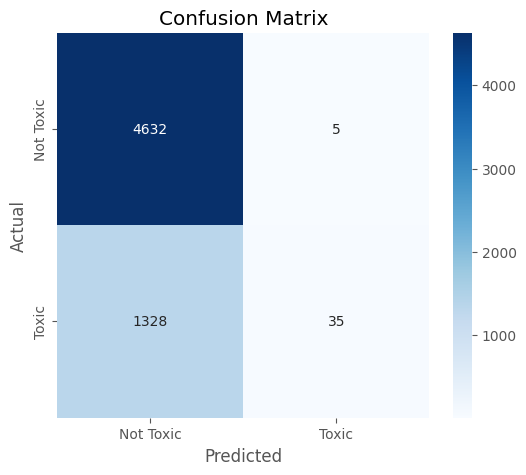

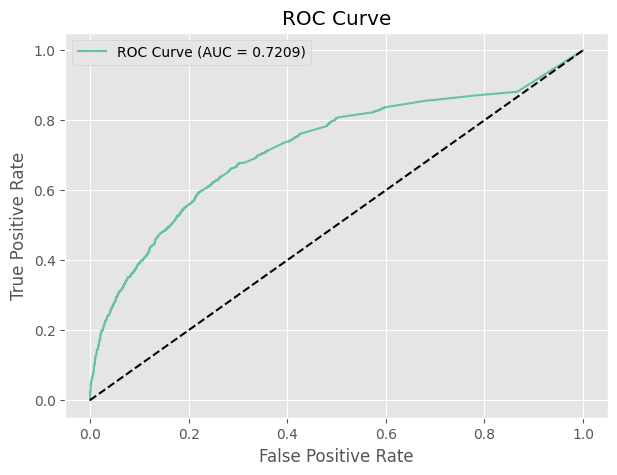

In [28]:
from sentence_transformers import SentenceTransformer

# Load multilingual sentence embedding model
model = SentenceTransformer('distiluse-base-multilingual-cased-v1') 

# Preprocess text
train_df_pt = train_df['feedback_text'].apply(text_preprocessing).apply(lambda x: ' '.join(x))
test_df_pt = test_df['content'].apply(text_preprocessing).apply(lambda x: ' '.join(x))

# Generate sentence embeddings
X_train_embed = model.encode(train_df_pt.tolist(), show_progress_bar=True)
X_test_embed = model.encode(test_df_pt.tolist(), show_progress_bar=True)

# Train classifier with Random Forest
clf = BinaryRelevance(RandomForestClassifier(n_estimators=100, max_depth=30, class_weight='balanced', n_jobs=-1, random_state=42))
clf.fit(X_train_embed, y_train)

# Predict
y_pred = clf.predict(X_test_embed).toarray()[:, 0]
y_proba = clf.predict_proba(X_test_embed).toarray()[:, 0]

# Evaluation
evaluate_model(y_test, y_pred, y_proba)

# **Advanced Models**

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Bidirectional, Embedding, LSTM, BatchNormalization, Dropout

### ***Cleaning Texts and Translating Text into English***

In [30]:
import re
import nltk
nltk.download('punkt')

# Apply translation if text is not in English
def translate_to_english(text, lang):
    if lang != 'en':
        try:
            return GoogleTranslator(source=lang, target='en').translate(text)
        except Exception as e:
            print(f"[Translation failed] Using original: {text[:50]}... | Reason: {e}")
            return text  
    else:
        return text

# Define a simple cleaning function
def clean_text(text, lang='en'):
    text = translate_to_english(text, lang)
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove digits
    text = text.strip()                  # remove leading/trailing whitespace
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    text = text.lower()                  # lowercase
    return text

# Apply to train and test data
train_dl = train_df['feedback_text'].apply(clean_text)
val_dl = val_df['feedback_text'].apply(clean_text)
test_dl = test_df.apply(lambda row: clean_text(row['content'], row['lang']), axis=1)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=  11.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=  11.9s
[CV] END classifier__C=0.0745934328572655, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear; total time=  11.5s
[CV] END classifier__C=0.006026889128682512, classifier__max_iter=300, classifier__penalty=l1, classifier__solver=liblinear; total time=  10.5s
[CV] END classifier__C=0.0019517224641449498, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=liblinear; total time=  10.9s
[CV] END classifier__C=0.0051800516442430215, classifier__max_iter=300, classifier__penalty=l2, classifier__solver=liblinear; total time=  11.1s
[CV] END classifier__C=0.0010090061869151559, classifier__max_iter=100, classifier__penalty=l1, classifier__solver=liblinear; total time=  10.2s
[CV] END classifier__C=0.033205591037519584, classifier__max_iter=200, classifi

### ***Tokenization and Padding***

In [31]:
# tokenizing the text
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<unkown>')

tokenizer.fit_on_texts(train_dl.values)

In [32]:
# Number of unique words found
word_index = tokenizer.word_index
print(f'Number of unique words found: {len(word_index)}')

Number of unique words found: 60886


In [33]:
# transform train and test data to tokens
train_tokens = tokenizer.texts_to_sequences(train_dl.values)
val_tokens = tokenizer.texts_to_sequences(val_dl.values)
test_tokens = tokenizer.texts_to_sequences(test_dl.values)

In [34]:
# Convert labels to float32
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [35]:
PAD_LENGTH = 200
train_padded = pad_sequences(train_tokens, maxlen=PAD_LENGTH, padding='post', truncating='post', value=0)
val_padded = pad_sequences(val_tokens, maxlen=PAD_LENGTH, padding='post', truncating='post', value=0)
test_padded = pad_sequences(test_tokens, maxlen=PAD_LENGTH, padding='post', truncating='post', value=0)

## ***LSTM***

In [36]:
# create the model
model = Sequential()
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=300, 
                    input_length=PAD_LENGTH, mask_zero=True))

# LSTM layer
model.add(LSTM(units= 50, dropout=0.4, return_sequences=False, use_cudnn=False))
# Dense layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

model.summary()

I0000 00:00:1744545546.751512      19 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14181 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 300)           │       3,000,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          70,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          26,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,229,482 (12.32 MB)

 Trainable params: 3,229,482 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# compile the model
model.compile(tf.keras.optimizers.Adam(learning_rate = 5e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(),tf.metrics.AUC(multi_label=True, name='auc')])

In [38]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

In [39]:
# fit the model
lstm_history = model.fit(train_padded, y_train,
                         validation_data = (val_padded, y_val),
                         batch_size=32,
                         epochs = 50, callbacks = callbacks)

Epoch 1/50


I0000 00:00:1744545553.058173    5555 service.cc:152] XLA service 0x78904869d550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744545553.058206    5555 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744545553.647388    5555 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/587 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - auc: 0.3861 - binary_accuracy: 0.7389 - loss: 0.6871

I0000 00:00:1744545556.344711    5555 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


587/587 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - auc: 0.6116 - binary_accuracy: 0.9435 - loss: 0.1992 - val_auc: 0.8331 - val_binary_accuracy: 0.9693 - val_loss: 0.0767 - learning_rate: 5.0000e-04
Epoch 2/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - auc: 0.8592 - binary_accuracy: 0.9715 - loss: 0.0621 - val_auc: 0.8933 - val_binary_accuracy: 0.9739 - val_loss: 0.0721 - learning_rate: 5.0000e-04
Epoch 3/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - auc: 0.9014 - binary_accuracy: 0.9747 - loss: 0.0519 - val_auc: 0.9187 - val_binary_accuracy: 0.9763 - val_loss: 0.0755 - learning_rate: 5.0000e-04
Epoch 4/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - auc: 0.9229 - binary_accuracy: 0.9768 - loss: 0.0443 - val_auc: 0.9323 - val_binary_accuracy: 0.9778 - val_loss: 0.0814 - learning_rate: 5.0000e-04
Epoch 5/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - auc: 0.9348 - binary_accuracy: 0.9782 - loss: 0.0361 - val_auc: 0.9411 - val_binary_accuracy: 0.9792 - val_loss: 0.0851 - learning_rate: 1.

### ***Model Evaluation on Test Set***

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Best Threshold: 0.1
Best F1 Score: 0.5280

Accuracy: 0.7908
Precision: 0.5417
Recall: 0.5150
F1 Score: 0.5280
ROC AUC: 0.7827

Confusion Matrix:
, [[4043  594]
 [ 661  702]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      4637
           1       0.54      0.52      0.53      1363

    accuracy                           0.79      6000
   macro avg       0.70      0.69      0.70      6000
weighted avg       0.79      0.79      0.79      6000



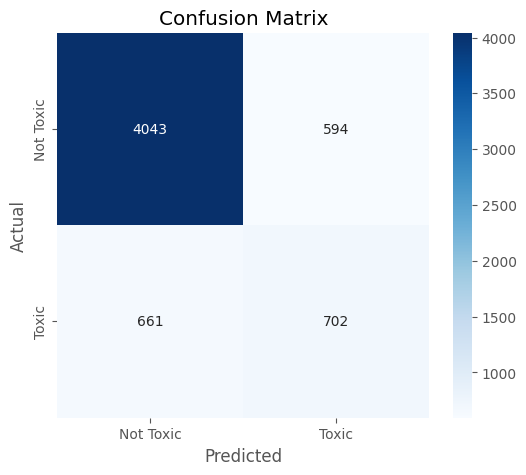

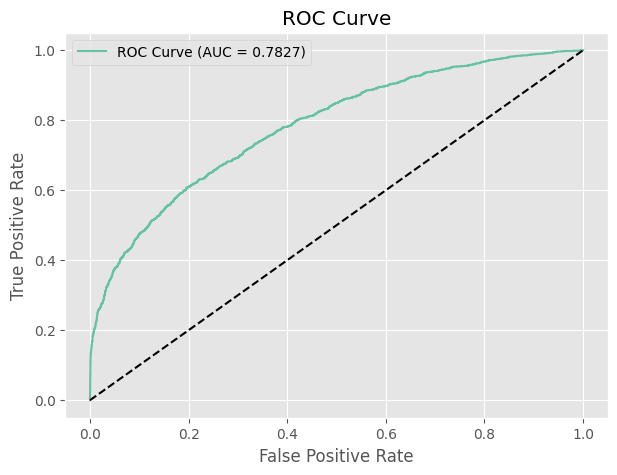

In [40]:
# Predict probabilities
y_proba = model.predict(test_padded)[:, 0]  # get the toxic column only (index 0)

# True labels (toxic column only)
y_true = y_test.astype(int)

# Try different thresholds to find the best one
thresholds = [i * 0.05 for i in range(1, 21)]  # 0.05 to 1.0
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute F1 separately to select best threshold
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}\n")

# Final prediction using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

evaluate_model(y_true, y_pred, y_proba)

## ***GRU***

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, BatchNormalization

# Create the model
model = Sequential()
model.add(Input(shape=(None,)))  

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE + 1, output_dim=300, 
                    input_length=PAD_LENGTH, mask_zero=True))

# GRU layer (replacing LSTM)
model.add(GRU(units=50, dropout=0.4, return_sequences=False, use_cudnn=False))

# Dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 300)           │       3,000,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50)                  │          52,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │          26,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,212,082 (12.25 MB)

 Trainable params: 3,212,082 (12.25 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# compile the model
model.compile(tf.keras.optimizers.Adam(learning_rate = 5e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(),tf.metrics.AUC(multi_label=True, name='auc')])

In [43]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

In [44]:
# fit the model
gru_history = model.fit(train_padded, y_train,
                         validation_data = (val_padded, y_val),
                         batch_size=32,
                         epochs = 50, callbacks = callbacks)

Epoch 1/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - auc: 0.5879 - binary_accuracy: 0.9360 - loss: 0.2115 - val_auc: 0.8232 - val_binary_accuracy: 0.9682 - val_loss: 0.0749 - learning_rate: 5.0000e-04
Epoch 2/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - auc: 0.8540 - binary_accuracy: 0.9705 - loss: 0.0619 - val_auc: 0.8964 - val_binary_accuracy: 0.9734 - val_loss: 0.0703 - learning_rate: 5.0000e-04
Epoch 3/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - auc: 0.9050 - binary_accuracy: 0.9743 - loss: 0.0509 - val_auc: 0.9201 - val_binary_accuracy: 0.9760 - val_loss: 0.0774 - learning_rate: 5.0000e-04
Epoch 4/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - auc: 0.9237 - binary_accuracy: 0.9764 - loss: 0.0448 - val_auc: 0.9334 - val_binary_accuracy: 0.9775 - val_loss: 0.0736 - learning_rate: 5.0000e-04
Epoch 5/50
587/587 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - auc: 0.9355 - binary_accuracy: 0.9779 - loss: 0.0361 - val_auc: 0.9428 - val_binary_accuracy: 0.9790 - val_loss: 0.0811 - learni

### ***Model Evaluation on Test Set***

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Best Threshold: 0.05
Best F1 Score: 0.5271

Accuracy: 0.8200
Precision: 0.6536
Recall: 0.4417
F1 Score: 0.5271
ROC AUC: 0.7980

Confusion Matrix:
, [[4318  319]
 [ 761  602]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      4637
           1       0.65      0.44      0.53      1363

    accuracy                           0.82      6000
   macro avg       0.75      0.69      0.71      6000
weighted avg       0.81      0.82      0.81      6000



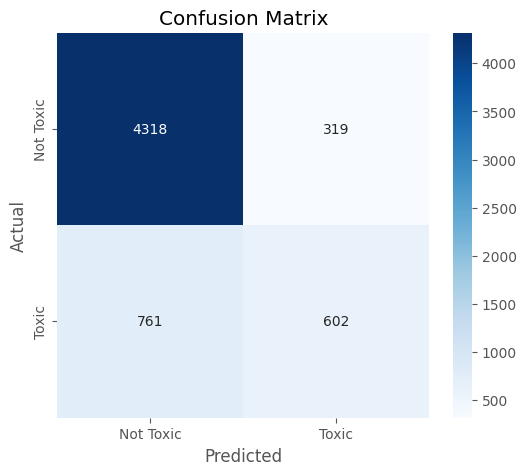

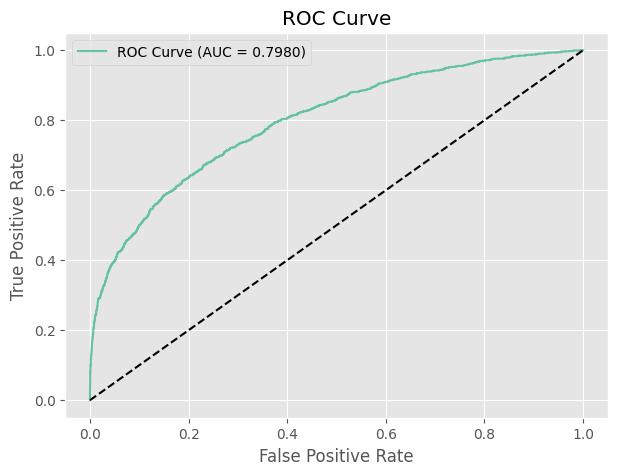

In [45]:
# Predict probabilities
y_proba = model.predict(test_padded)[:, 0]  # get the toxic column only (index 0)

# True labels (toxic column only)
y_true = y_test.astype(int)

# Try different thresholds to find the best one
thresholds = [i * 0.05 for i in range(1, 21)]  # 0.05 to 1.0
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute F1 separately to select best threshold
    f1 = f1_score(y_true, y_pred)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1:.4f}\n")

# Final prediction using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

evaluate_model(y_true, y_pred, y_proba)